In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [3]:
DENSE = True
EPS = 120
LAG = 12 + 1
# SROUTE = [
#     '403259-401851', 
#     '401851-401852'
# ]
SROUTE = [
    '400860-400861', 
#     '400861-403781',
#     '400861-400948',
#     '400861-405376',
]
STOPS = len(SROUTE)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
dset = SpotHistory(SROUTE, 'train', 16, lag=LAG, res=10).generator()
evalset = SpotHistory(SROUTE, 'test', 16, lag=LAG, res=10).generator()

Chunks (lag 13)
 [*] Segments: 90 co-avail
    * [400860-400861]: 90
 [*] Examples (train): 11749
Chunks (lag 13)
 [*] Segments: 90 co-avail
    * [400860-400861]: 90
 [*] Examples (test): 11749


In [5]:
from models.Linear import *
# lag = 6th timestep is predicted based on past 5 (50 mins
if DENSE:
    model = Dense(lag=LAG-1, stops=STOPS).to(device)
else:
    model = Linear(lag=LAG-1, stops=STOPS).to(device)
model.device = device
criterion, opt, sch = model.params(lr=0.001)
evaluate(evalset, model, crit=lambda _y, y: criterion(_y[:, 0], y[:, 0]).item())

Eval loss: 112.1504     


In [6]:
losses = []
eval_mse = []
eval_mape = []
from numpy.random import randint
for eii  in range(EPS):
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        sys.stdout.write('[%d/%d : %d/%d] - L%.2f      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            10**2 * loss.item()
        ))
    sys.stdout.write('\n')

    eval_mse.append(
        evaluate(
            evalset, model, 
            crit=lambda y, _y: criterion(y[:, 0], _y[:, 0]).item(), result=True))
    sys.stdout.flush()
    sch.step()

[1/120 : 735/735] - L1.09       
Eval loss: 2.91225     
[2/120 : 735/735] - L1.30       
Eval loss: 2.64184     
[3/120 : 735/735] - L0.45       
Eval loss: 2.39290     
[4/120 : 735/735] - L0.35       
Eval loss: 2.19306     
[5/120 : 735/735] - L1.27       
Eval loss: 2.00873     
[6/120 : 735/735] - L0.88       
Eval loss: 1.84635     
[7/120 : 735/735] - L1.10       
Eval loss: 1.70500     
[8/120 : 735/735] - L0.70       
Eval loss: 1.56909     
[9/120 : 735/735] - L0.64       
Eval loss: 1.44279     
[10/120 : 735/735] - L0.56       
Eval loss: 1.33930     
[11/120 : 735/735] - L0.14       
Eval loss: 1.23482    
[12/120 : 735/735] - L0.54       
Eval loss: 1.15328    
[13/120 : 735/735] - L2.20       
Eval loss: 1.08039    
[14/120 : 735/735] - L0.51       
Eval loss: 1.01747    
[15/120 : 735/735] - L0.75       
Eval loss: 0.95877    
[16/120 : 735/735] - L1.07      
Eval loss: 0.91503    
[17/120 : 735/735] - L0.86      
Eval loss: 0.86622    
[18/120 : 735/735] - L2.49      

In [7]:
# torch.save(model.state_dict(), 'checkpoints/dense.pth')

Eval segments: 18
Eval MSE: 2.7873


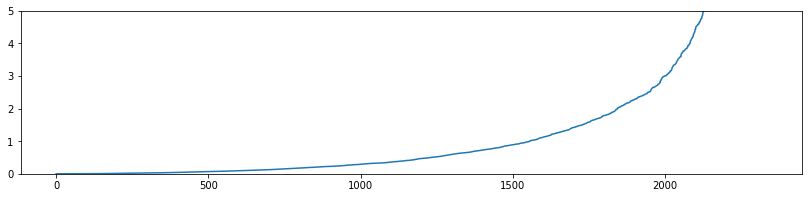

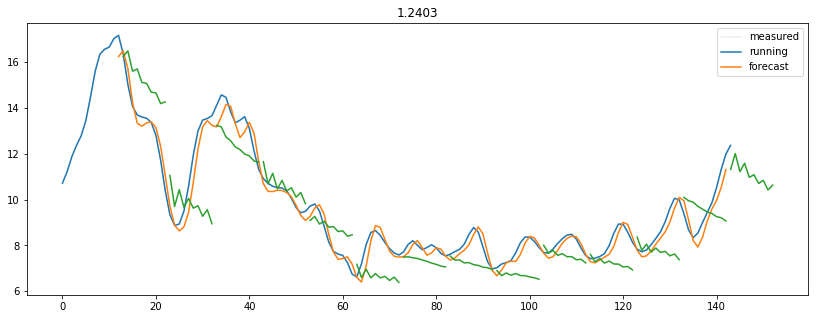

In [8]:
from utils import *
viewset = SpotHistory(SROUTE, 'test', 16, lag=None, res=10, shuffle=False, verbose=False)
mses = []

sqerr = eval_lin(viewset, model, test_lag=LAG-1, fmax=10, plot=False)
print('Eval segments:', len(viewset))
print('Eval MSE: %.4f' % np.mean(sqerr))

plt.figure(figsize=(14, 3))
plt.plot(sorted(sqerr)); plt.ylim(0, 5)
plt.show(); plt.close()

_ = eval_lin(viewset[:1], model, test_lag=LAG-1, fmax=10, plot=True)